In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models#type:ignore
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing import image #type:ignore
from tensorflow.keras.callbacks import EarlyStopping#type:ignore
from tensorflow.keras.preprocessing.image import ImageDataGenerator#type:ignore
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import precision_recall_curve, average_precision_score,precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc

2025-04-17 15:57:53.705445: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744905473.974218      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744905474.048194      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Set memory growth to prevent TensorFlow from consuming all GPU memory at once
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

Num GPUs Available:  1


In [18]:
train_datagen = ImageDataGenerator(rescale=1./255,)
train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/eurosat-rgb/EuroSAT_RGB',
    target_size=(250, 250),
    batch_size=16,
    class_mode='categorical'
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split = 0.2
)

test_generator = test_datagen.flow_from_directory(
    '/kaggle/input/eurosat-rgb/EuroSAT_RGB',
    target_size=(250, 250),
    batch_size=16,
    class_mode='categorical',
    shuffle=False  # Important for confusion matrix
)

Found 27000 images belonging to 10 classes.
Found 27000 images belonging to 10 classes.


In [19]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(250, 250, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(512, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    
    # Add more dense layers
    layers.Dense(1024, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),

    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    

    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),

    # Final output layer
    layers.Dense(10, activation='softmax')
])

In [20]:

from tensorflow.keras.callbacks import ModelCheckpoint
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint("model_epoch_{epoch:02d}.keras",  # Save file as 'model_epoch_01.h5', 'model_epoch_02.h5', etc.
                             save_weights_only=False,  # Saves the entire model (architecture + weights)
                             save_freq='epoch',        # Save after every epoch
                             verbose=1)

In [21]:
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=test_generator,
    callbacks=[early_stopping,checkpoint],
    batch_size=32
)

Epoch 1/50
1686/1688 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5386 - loss: 1.4651
Epoch 1: saving model to model_epoch_01.keras
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 106s 56ms/step - accuracy: 0.5388 - loss: 1.4647 - val_accuracy: 0.6772 - val_loss: 0.9072
Epoch 2/50
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7070 - loss: 0.9090
Epoch 2: saving model to model_epoch_02.keras
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 88s 52ms/step - accuracy: 0.7070 - loss: 0.9089 - val_accuracy: 0.7909 - val_loss: 0.5844
Epoch 3/50
1686/1688 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7704 - loss: 0.7031
Epoch 3: saving model to model_epoch_03.keras
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 89s 53ms/step - accuracy: 0.7704 - loss: 0.7030 - val_accuracy: 0.8249 - val_loss: 0.5073
Epoch 4/50
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8119 - loss: 0.5735
Epoch 4: saving model to model_epoch_04.keras
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 85s 51ms/step - accuracy: 0.8119 - loss: 0.5735 - val_accuracy: 0

1688/1688 ━━━━━━━━━━━━━━━━━━━━ 44s 26ms/step

Classification Report:

                      precision    recall  f1-score   support

          AnnualCrop       1.00      1.00      1.00      3000
              Forest       1.00      1.00      1.00      3000
HerbaceousVegetation       1.00      1.00      1.00      3000
             Highway       1.00      1.00      1.00      2500
          Industrial       1.00      1.00      1.00      2500
             Pasture       1.00      1.00      1.00      2000
       PermanentCrop       1.00      1.00      1.00      2500
         Residential       1.00      1.00      1.00      3000
               River       1.00      1.00      1.00      2500
             SeaLake       1.00      1.00      1.00      3000

            accuracy                           1.00     27000
           macro avg       1.00      1.00      1.00     27000
        weighted avg       1.00      1.00      1.00     27000



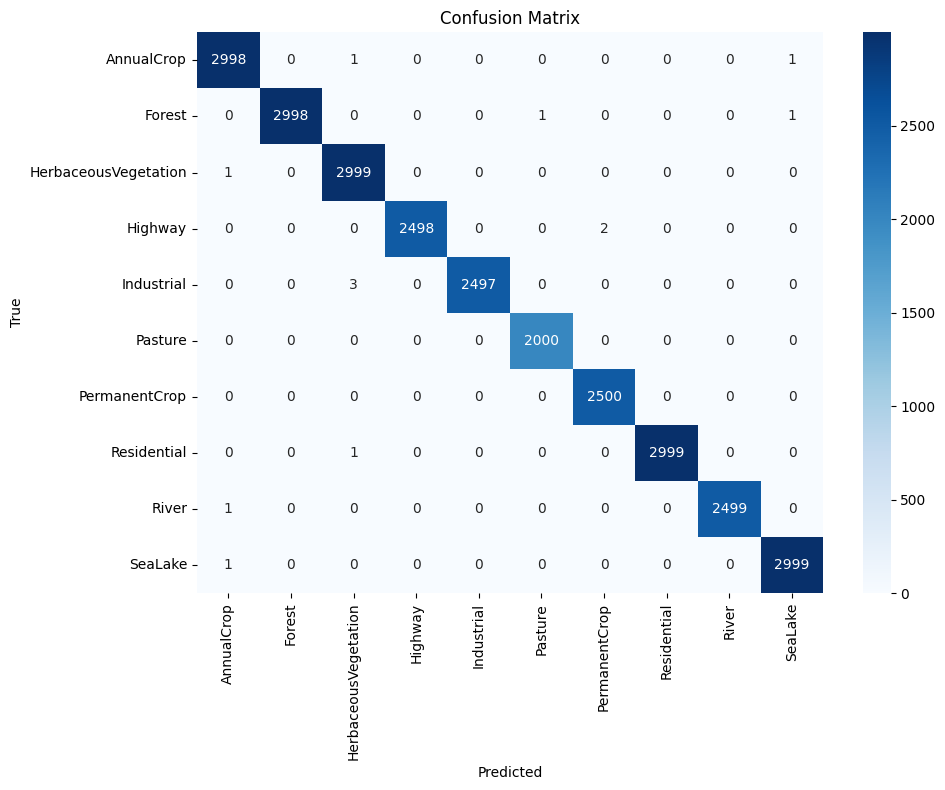

In [22]:
predictions = model.predict(test_generator, verbose=1)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Step 3: Classification Report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Step 4: Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

# Step 5: Plot Training History
# Assuming you have 'history' object from model.fit()
def plot_history(history):
    # Accuracy
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


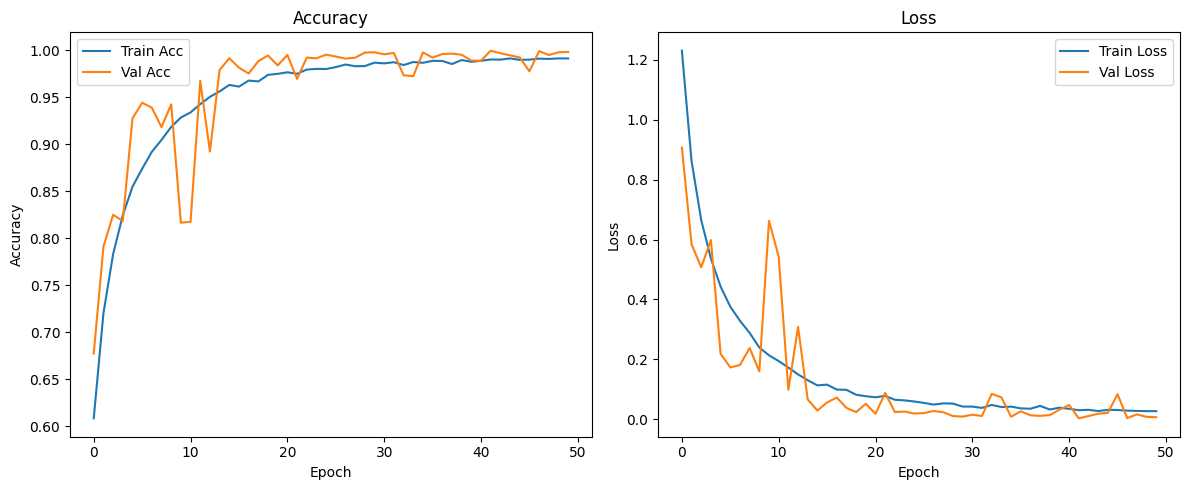

In [24]:
plot_history(history)

In [26]:
model.save("Final_Satellite_model.h5")

In [29]:
print("Hello World")

Hello World


In [30]:
import tensorflow as tf
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

# Create concrete function
full_model = tf.function(lambda x: model(x))
full_model = full_model.get_concrete_function(tf.TensorSpec(shape=(1, 250, 250, 3), dtype=tf.float32))

# Get frozen ConcreteFunction
frozen_func = convert_variables_to_constants_v2(full_model)
graph_def = frozen_func.graph.as_graph_def()

# Calculate FLOPs
with tf.Graph().as_default() as graph:
    tf.graph_util.import_graph_def(graph_def, name='')
    run_meta = tf.compat.v1.RunMetadata()
    opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
    flops = tf.compat.v1.profiler.profile(graph=graph, run_meta=run_meta, cmd='op', options=opts)

print(f"FLOPs: {flops.total_float_ops}")


I0000 00:00:1744947796.199924      31 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
I0000 00:00:1744947796.200187      31 single_machine.cc:361] Starting new session
I0000 00:00:1744947796.206981      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0



=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
op: The nodes are operation kernel type, such as MatMul, Conv2D. Graph nodes belonging to the same type are aggregated together.
flops: Number of float operations. Note: Please read the implementation for th

In [31]:
import time
import numpy as np

# Random image input with same shape
x = np.random.rand(1, 250, 250, 3).astype(np.float32)

# Warmup
model.predict(x)

# Time it
start_time = time.time()
model.predict(x)
end_time = time.time()

print(f"Inference Time: {(end_time - start_time)*1000:.2f} ms")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Inference Time: 59.26 ms


In [32]:
model.save("my_model.h5")
import os
print(f"Model Size: {os.path.getsize('my_model.h5') / 1024**2:.2f} MB")


Model Size: 175.73 MB
